# Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import helpers

tf.reset_default_graph()
sess = tf.InteractiveSession()

In [2]:
tf.__version__

'1.0.1'

# Define model parameters sizes

In [3]:
#PAD = 0
#EOS = 1
#vocab_size = 10
train_batch_, val_batch_, test_batch, vocab_size = helpers.load_y_labels()
print vocab_size
PAD = vocab_size + 1
EOS = vocab_size + 2
input_embedding_size = 20
encoder_hidden_units = 20

55


# Define input, output and weights

In [4]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
encoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_targets')

In [5]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

In [6]:
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)

In [7]:
encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)

encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
    encoder_cell, encoder_inputs_embedded,
    dtype=tf.float32, time_major=True,
)

In [8]:
encoder_logits = tf.contrib.layers.linear(encoder_outputs, vocab_size)

encoder_prediction = tf.argmax(encoder_logits, 2)

In [9]:
encoder_logits

<tf.Tensor 'fully_connected/Reshape_1:0' shape=(?, ?, 55) dtype=float32>

# Define loss

In [10]:
# stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
#     labels=tf.one_hot(encoder_targets, depth=vocab_size, dtype=tf.float32),
#     logits=encoder_logits,
# )

stepwise_cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=tf.transpose(encoder_targets),
    logits=encoder_logits
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

# Initialize variables

In [11]:
sess.run(tf.global_variables_initializer())

# Verify forward pass

In [12]:
train_batch_, train_batch_length_ = helpers.batch(train_batch_)
print('batch_encoded:\n' + str(train_batch_))

pred_ = sess.run(encoder_prediction,
    feed_dict={
        encoder_inputs: train_batch_,
        #encoder_inputs: train_batch_        
    })
print('encoder predictions:\n' + str(pred_))

batch_encoded:
[[45  0  5  0  0 13 14  2  0]
 [22  0 39  0 20 24  0  2 35]
 [30  0  0  0  0  0  4  3 28]
 [34  8  0  0  5  0 19 26 47]
 [40 18  0  0 50  0 41 38 44]
 [53 16  0 54 12  0 11  7 23]
 [32  6 25  0 49  0  4  3 21]
 [17  9 10  0 52  0 15  2 51]
 [33 37 48  0 42  0 46  0 27]
 [29  0 36  0  0  0 31  0 43]]
encoder predictions:
[[ 8 46 10 46 46 47 29 24 46]
 [51 17 18 17 35 12 53 24  0]
 [37 17 18 17 45 46 29 43 46]
 [37 32  0 17 17 46 13 30 45]
 [44 17 17 17  8 46 52 37  3]
 [18 46 17 17 45 46 52 19 45]
 [18 35  0 32  8 17 44 46 50]
 [18 32 45 17  9 17 18 11 29]
 [18 50  8 17  5 17 42 46 45]
 [44 50 47 17 46 17 37 46 46]]


# Read and load data in time-major-form in batches

In [13]:
#batch_size = 100
batch_size = 2

batches = helpers.read_and_load_data(train_batch_, batch_size)
#store = next(batches)
#print(store)
#print(helpers.batch(store))
#print(next(batches))


In [14]:
def next_feed():
    batch = next(batches)
    #print type(batch)
    #print batch
    X_feed = helpers.batch(batch)[0]
    #print X_feed
    #print X_feed.shape
    return {
        encoder_inputs: X_feed[0:-1,:],
        encoder_targets: X_feed[1:,:]
    }



In [15]:
#print(next_feed())
loss_track = []

In [16]:
max_batches = 3001
#batches_in_epoch = 1000
batches_in_epoch = 2

try:
    for batch in range(22):
        #print "taking next et of files....."
        fd = next_feed()
        #print(fd)
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(encoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()
except Exception as e:
    print('Training done')

batch 0
  minibatch loss: 3.97242450714
  sample 1:
    input     > [45  0  5  0  0 13 14  2]
    predicted > [ 8  6 46 46 46 46 29 18]
  sample 2:
    input     > [22  0 39  0 20 24  0  2]
    predicted > [37 39  0  0  0 45 45 18]
()
batch 2
  minibatch loss: 4.00921440125
  sample 1:
    input     > [40 18  0  0 50  0 41 38]
    predicted > [15 10 17 17  8 46 32 32]
  sample 2:
    input     > [53 16  0 54 12  0 11  7]
    predicted > [18  0  0  0 45 45  0 45]
()
batch 4
  minibatch loss: 3.97061729431
  sample 1:
    input     > [33 37 48  0 42  0 46  0]
    predicted > [51 51 34  4  4  0 42  0]
  sample 2:
    input     > [29  0 36  0  0  0 31  0]
    predicted > [44 44 44  6  6  6 17 17]
()
Training done


/Users/ashutoshchoudhary/Anaconda/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


loss 3.9771 after 10 examples (batch_size=2)


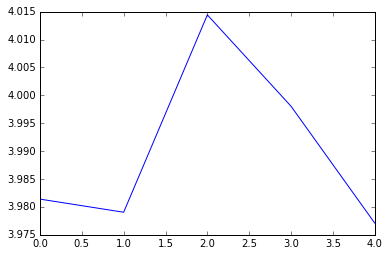

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))